# MACHINE LEARNING PROJECT - Find hate - offensive speech tweets.

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
import time
%matplotlib inline

Now we read our translated dataset.
The method of translation may be found in tweet_translator notebook.
We use pandas describe() in order to see the details of our dataset, for excample mean, std etc.

In [2]:
df = pd.read_csv("mytrain_dataset.csv",sep="\t",error_bad_lines=True)
df.describe()

,id,count,hate_speech,offensive_language,neither,class
count,18127.000000,18127.000000,18127.000000,18127.000000,18127.000000,18127.000000
mean,11230.522922,3.242566,0.290782,2.393943,0.557842,1.109119
std,6707.057897,0.883681,0.645830,1.405367,1.128241,0.470360
min,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,5520.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,10175.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,17860.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,22466.000000,9.000000,7.000000,9.000000,9.000000,2.000000



<h6>Columns key:</h6>

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users.
<h6>1</h6> - hate speech
<h6>2</h6> - offensive  language
<h6>3</h6> - neither
tweet = raw tweet text

<h6>Below we can see the histogramm of our 3 classes contained in the dataset</h6>

<AxesSubplot:>

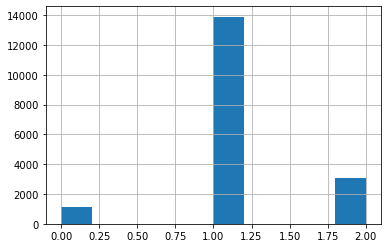

In [3]:
df['class'].hist()

In [4]:
tweets=df.tweet

<h3> Feature Generation </h3>

In [5]:
#dowload stop words for greek language

nltk.download('stopwords')
stopwords=stopwords = nltk.corpus.stopwords.words("greek")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

[nltk_data] Downloading package stopwords to /home/penny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets.values.astype('U')).toarray()  ## Even astype(str) would work
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/home/penny/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['f', 'r', 't'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [8]:
#Get POS tags for tweets and save as a string
nltk.download('averaged_perceptron_tagger')
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(str(t)))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/penny/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [10]:
#Construct POS TF matrix and get vocab dict
# print(tweet_tags)
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [11]:
#Now get other features
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    ##SENTIMENT
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet) #Count #, @, and http://
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
#         print(type(t))
        if t is not None:
#             print(t)
            feats.append(other_features(t))
    return np.array(feats)


In [12]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", "vader compound", \
                        "num_hashtags", "num_mentions", "num_urls", "is_retweet"]


In [13]:
feats = get_feature_array(tweets)

In [14]:
#Now join them all up
from sklearn.decomposition import PCA

M = np.concatenate([tfidf,pos, feats],axis=1)
M.shape
print(M.shape)

#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

(18127, 5067)


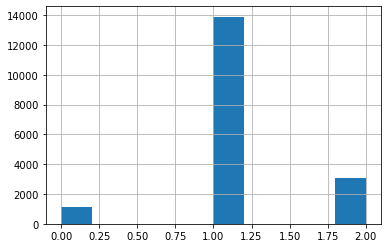

In [15]:
X = pd.DataFrame(M)
# print(X)
df['class'] = pd.to_numeric(df['class'], errors='coerce')
df = df.dropna(subset=['class'])
# print(df['class'])
y= df['class'].astype(int)
#True distribution
y.hist()
#for cross validation
X1 = pd.DataFrame(M)
# print(X)
df['class'] = pd.to_numeric(df['class'], errors='coerce')
df = df.dropna(subset=['class'])
# print(df['class'])
y1= df['class'].astype(int)


<h4>Logistic Regression Classifier</h4>
Calculate Time and print report.

In [17]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
times = []

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
tic = time.time()
clfLR = LogisticRegression(class_weight='balanced',penalty="l2", C=0.01)
clfLR.fit(X_train,y_train)
lr_y_preds = clfLR.predict(X_test)
print("Logistic Regression time:",time.time() - tic,'\n')
report = classification_report( y_test, lr_y_preds )
print(report)

Logistic Regression time: 12.335524082183838 

              precision    recall  f1-score   support

           0       0.13      0.36      0.19       135
           1       0.84      0.58      0.69      1384
           2       0.32      0.51      0.39       294

    accuracy                           0.55      1813
   macro avg       0.43      0.48      0.42      1813
weighted avg       0.70      0.55      0.60      1813



/home/penny/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<h3>Confusion matrix for Logistic Regression</h3>

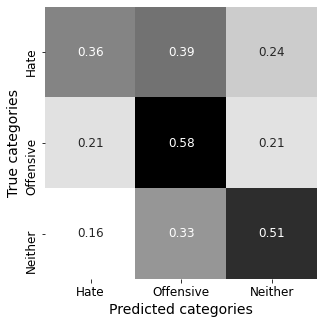

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,lr_y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)



#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

<AxesSubplot:>

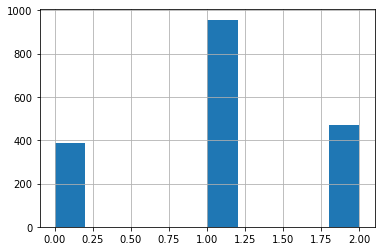

In [19]:
pd.Series(lr_y_preds).hist()

<h4>GuassianNB Classifier</h4>
Calculate Time and print report.

In [20]:
from sklearn.naive_bayes import GaussianNB
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=42, test_size=0.1)
tic = time.time()
clfNB = GaussianNB()
clfNB.fit(X_train,y_train)
nb_y_preds = clfNB.predict(X_test)
print("GaussianNB run time:",time.time() - tic,'\n')
report2 = classification_report(y_test, nb_y_preds)
print (report2)

GaussianNB run time: 0.8815405368804932 

              precision    recall  f1-score   support

           0       0.08      0.64      0.14       135
           1       0.79      0.23      0.36      1384
           2       0.33      0.34      0.33       294

    accuracy                           0.28      1813
   macro avg       0.40      0.40      0.28      1813
weighted avg       0.66      0.28      0.34      1813



<h3>Confusion matrix for Gaussian NB</h3>

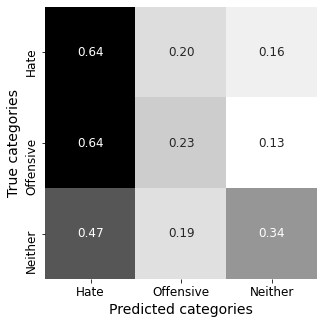

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test,nb_y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)


<AxesSubplot:>

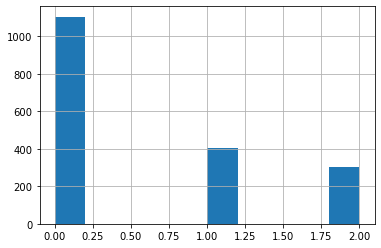

In [22]:
pd.Series(nb_y_preds).hist()

<h4>KNeighbors Classifier</h4>
Calculate Time and print report.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
tic = time.time()
classifier = KNeighborsClassifier(n_neighbors = 2)
classifier.fit(X_train,y_train)
knn_y_predict = classifier.predict(X_test)
print("KNN run time:",time.time() - tic,'\n')
report3 = classification_report(y_test, knn_y_predict)
print(report3)

KNN run time: 32.43400049209595 

              precision    recall  f1-score   support

           0       0.16      0.23      0.19       135
           1       0.79      0.88      0.83      1384
           2       0.51      0.10      0.17       294

    accuracy                           0.71      1813
   macro avg       0.48      0.40      0.39      1813
weighted avg       0.69      0.71      0.68      1813



<h3>Confusion matrix for KNN</h3>

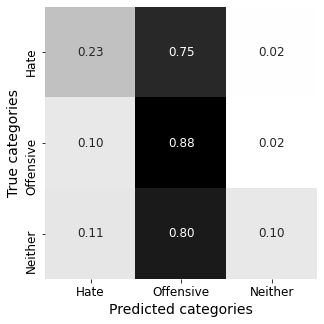

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test,knn_y_predict)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)


<AxesSubplot:>

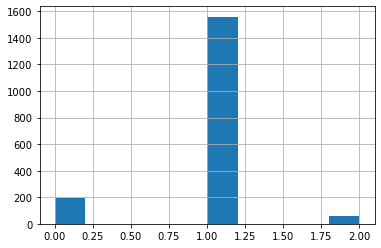

In [25]:
pd.Series(knn_y_predict).hist()

<h4>XGB Classifier</h4>
Calculate Time and print report.

In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

tic = time.time()
xg_reg = xgb.XGBClassifier(objective ='reg:linear')
xg_reg.fit(X_train,y_train)
xg_y_preds = xg_reg.predict(X_test)
print("XGB run time:",time.time() - tic,'\n')
report4 = classification_report(y_test, xg_y_preds)
print(report4)


/home/penny/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:58:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB run time: 168.84296131134033 

              precision    recall  f1-score   support

           0       0.50      0.01      0.03       135
           1       0.79      0.98      0.87      1384
           2       0.64      0.20      0.31       294

    accuracy                           0.78      1813
   macro avg       0.64      0.40      0.40      1813
weighted avg       0.74      0.78      0.72      1813



<h3>Confusion matrix for XGB</h3>

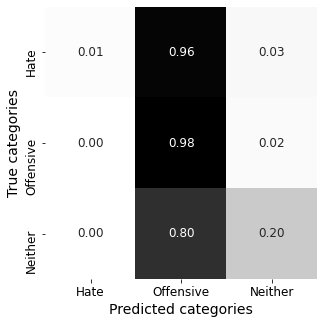

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test,xg_y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

<AxesSubplot:>

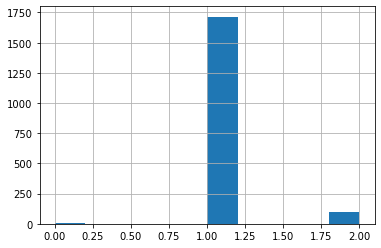

In [28]:
pd.Series(xg_y_preds).hist()

<h5>Cross Validation for 3 out of 4 classifiers</h5>

<h6>K-Fold for Logistic Regression model</h6>

/home/penny/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/penny/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

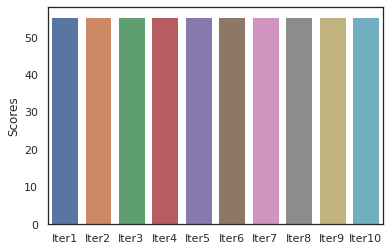

Accurracy for every model:  [55.37782680639823, 55.37782680639823, 55.37782680639823, 55.37782680639823, 55.37782680639823, 55.37782680639823, 55.37782680639823, 55.37782680639823, 55.37782680639823, 55.37782680639823]


In [29]:
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42, test_size=0.1)
accuracy_model_LG=[]

kf = KFold(n_splits=10,shuffle=True)


for train_index, test_index in kf.split(X1, y1):
    clfLR = LogisticRegression(class_weight='balanced',penalty="l2", C=0.01)
    clfLR.fit(X_train,y_train)
    lr_y_preds = clfLR.predict(X_test)
    accuracy_model_LG.append(accuracy_score(y_test, clfLR.predict(X_test), normalize=True)*100)
    
scores = pd.DataFrame(accuracy_model_LG,columns=['Scores'])
 
sns.set(style="white", rc={"lines.linewidth": 3})
sns.barplot(x=['Iter1','Iter2','Iter3','Iter4','Iter5','Iter6','Iter7','Iter8','Iter9','Iter10'],y="Scores",data=scores)
plt.show()
sns.set()

print("Accurracy for every model: ",accuracy_model_LG)


In [ ]:
<h6>K-Fold for KNN model</h6>

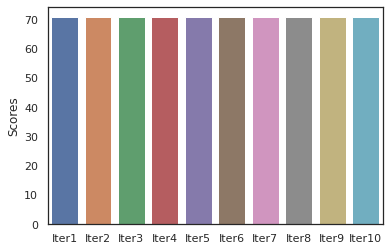

Accurracy for every model:  [70.82184225041368, 70.82184225041368, 70.82184225041368, 70.82184225041368, 70.82184225041368, 70.82184225041368, 70.82184225041368, 70.82184225041368, 70.82184225041368, 70.82184225041368]


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42, test_size=0.1)
accuracy_model_KNN=[]

kf = KFold(n_splits=10,shuffle=False)


for train_index, test_index in kf.split(X1, y1):
    classifier = KNeighborsClassifier(n_neighbors = 2)
    classifier.fit(X_train,y_train)
    accuracy_model_KNN.append(accuracy_score(y_test, classifier.predict(X_test), normalize=True)*100)
    
scores = pd.DataFrame(accuracy_model_KNN,columns=['Scores'])
 
sns.set(style="white", rc={"lines.linewidth": 3})
sns.barplot(x=['Iter1','Iter2','Iter3','Iter4','Iter5','Iter6','Iter7','Iter8','Iter9','Iter10'],y="Scores",data=scores)
plt.show()
sns.set()

print("Accurracy for every model: ",accuracy_model_KNN)

In [ ]:
<h6>K-Fold for XBG model</h6>

/home/penny/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:40:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

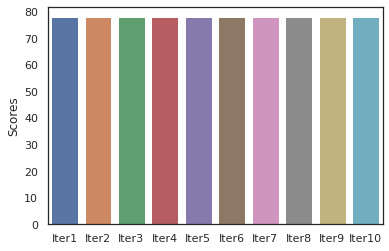

Accuracy for every model:  [77.99227799227799, 77.99227799227799, 77.99227799227799, 77.99227799227799, 77.99227799227799, 77.99227799227799, 77.99227799227799, 77.99227799227799, 77.99227799227799, 77.99227799227799]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42, test_size=0.1)
accuracy_model_XBG=[]

kf = KFold(n_splits=10,shuffle=True)


for train_index, test_index in kf.split(X1, y1):
    xg_reg = xgb.XGBClassifier(objective ='reg:linear')
    xg_reg.fit(X_train,y_train)

#     xg_y_preds = xg_reg.predict(X_test)
    accuracy_model_XBG.append(accuracy_score(y_test, xg_reg.predict(X_test), normalize=True)*100)
    
scores = pd.DataFrame(accuracy_model_XBG,columns=['Scores'])
 
sns.set(style="white", rc={"lines.linewidth": 3})
sns.barplot(x=['Iter1','Iter2','Iter3','Iter4','Iter5','Iter6','Iter7','Iter8','Iter9','Iter10'],y="Scores",data=scores)
plt.show()
sns.set()

print("Accuracy for every model: ",accuracy_model_XBG)